# W207 Final Project

- Authors: Christian Millsop, Chris Ventura, Stanley Ye
- Kaggle Project: [Airbnb New User Bookings](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/data)
- GitHub Repo: [w207_final_airbnb](https://github.com/cmventura/w207_final_airbnb)

## Table of Contents

- Introduction
- Exploratory Data Analysis
- Model Selection Methodology And Analysis
- Conclusion
- References

# Introduction

For this paper, we will use various machine learning models to complete the Airbnb new user bookings Kaggle competition.  This competition was originally designed as a recruiting tool for Airbnb.  The stated goal of this competition is to predict in which country a new user will make their first booking<sup>[1]</sup>.  To complete this challenge, Airbnb and Kaggle have provided several datasets consisting of user demographics, summary statistics, and web session information to try to predict a target variable consisting of the country in which a user made their first booking.  Given that our core problem is to predict where users will make their first booking, we will attempt to answer the following research question: What is the relationship of a user profile and online activity within the Airbnb website to the travel destination?

To answer this question we will optimize and combine several machine learning models to generate accurate destination predictions.  We will be using both derived and raw features from the datasets as inputs to these models.  Using known best practices<sup>[2][3]</sup> to examine the effect of the various features on the end predictions.  This will show both the effectiveness of various models as well as the relative importance of each feature at predicting accurate destinations.  After examination, we will be able to answer our initial research question by identifying which aspects of a user’s profile and online activity have a relationship to the selection of one or more travel destinations.

While we will be optimizing our models to accurately predict the destination country, the Kaggle competition allows for up to five predictions per user.  The competition uses the following Normalized Discounted Cumulative Gain (NDCG) formula to score results<sup>[4]</sup>:

<img src="ndcg_formula.png" align="center"/>

# Exploratory Data Analysis

In [1]:
# Import libraries.
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning) 

In [2]:
# Import data files from Kaggle.
DATA_PATH = './data/extracted'
dfs_raw = {}
dfs = {}
for root, dirs, files in os.walk(DATA_PATH):
    for file in files:
        dfs[file.split('.')[0]] = pd.read_csv(f'{DATA_PATH}/{file}')
        print(file)

age_gender_bkts.csv
countries.csv
sample_submission_NDF.csv
sessions.csv
test_users.csv
train_users_2.csv


## Dataset: age_gender_bkts

Description: This file contains demographic information for each of the possible destination countries.  The demographics are bucketed into age ranges with gender and population count by year.
  + The age_bucket is top-coded at 100+
  + All data is for the year 2015.  If we use this data for analysis then we need to assume that the demographic trends hold for all yeears in our user dataset.

Relevance: Demographic information of the destination of the destination country might be correlated to the the gender and age of the user.

In [3]:
dfs['age_gender_bkts'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 5 columns):
age_bucket                 420 non-null object
country_destination        420 non-null object
gender                     420 non-null object
population_in_thousands    420 non-null float64
year                       420 non-null float64
dtypes: float64(2), object(3)
memory usage: 16.5+ KB


In [4]:
dfs['age_gender_bkts'].head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


## Dataset: countries

Description: Information about the destination countries, including the location and language spoken at each of the countries as well as the distance of the location and language compared to the USA (origin country).  The language codes need to be modified in order to match with the language codes used in the user datasets.

Relevance:
+ Countries may be clustered by similarity to each other and by dissimilarity to the origin country.
+ Specific characteristics of the traveler and destination might have a correlation.

In [5]:
dfs['countries'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
country_destination              10 non-null object
lat_destination                  10 non-null float64
lng_destination                  10 non-null float64
distance_km                      10 non-null float64
destination_km2                  10 non-null float64
destination_language             10 non-null object
language_levenshtein_distance    10 non-null float64
dtypes: float64(5), object(2)
memory usage: 640.0+ bytes


In [6]:
dfs['countries']

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


## Dataset: sample_submission_NDF

Description: The results of our analysis should match the format of this file.

Relevance: This is not relevant to the analysis.

In [7]:
dfs['sample_submission_NDF'].head()

,id,country
0,5uwns89zht,NDF
1,jtl0dijy2j,NDF
2,xx0ulgorjt,NDF
3,6c6puo6ix0,NDF
4,czqhjk3yfe,NDF


## Dataset: sessions

Description: User session data on the Airbnb website.  A session is a sequence of actions performed on the website.
+ secs_elapsed = The amount of time between that action and the prior action.
+ There is no session_id column and some of the secs_elapsed columns are extremely long.  We will assume that all visits to Airbnb are aggregated into a single session per user.  The large secs_elapsed are the intervals between user visits to Airbnb.
+ The dataset does not tell us what searches the user performed (ie. related to a destination), only that a user was searching or interacting with the Airbnb platform in some way.
+ device_type = Device that the user performed the action from
 + If the device changes over time is the user more engaged in making a booking through AirBnB?

Relevance:
+ It's hard to pinpoint the "hard" relevance of this dataset.  It could be used to develop an understanding of user interest/engagement or to identify whether a user has specific concerns/requirements related to their destination.
+ Some actions appear interesting: "view_ghosting_reasons", "special_offer_field", "airbnb_picks_wishlists"

In [8]:
dfs['sessions'].info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
user_id          10533241 non-null object
action           10488111 non-null object
action_type      9441533 non-null object
action_detail    9441533 non-null object
device_type      10567737 non-null object
secs_elapsed     10431706 non-null float64
dtypes: float64(1), object(5)
memory usage: 483.8+ MB


In [9]:
dfs['sessions'].head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


## Dataset: train_users_2

Description: This dataset contains the main training data.  Each row is a user profile and contains basic information as well the chosen destination.
+ date_first_booking has NaN values. We'll accept these into the dataset since they correspond to NDF destinations.
+ first_affiliate_tracked also has a significant number of NaN.
+ Age has outliers as well as NaN values.  Since this data comes from user input, we don't have any guarantees as to data validation.  Instead of omitting the outliers, we'll bucket and top-code age.
+ A significant number of gender values are non-binary.  We should be careful to transform the gender column into separate categorical features for each of the options.
+ ~half of the dataset did not choose a destination, most of the rest went to the US.  This will make it difficult to identify if people are going to specific foreign countries since the data related to those outcomes is relatively limited.
+ unknown gender and NDF are highly correlated
+ When a destination_country speaks the same language as the user, there is an increased probability that the user will go to that country.  However, users overwhelming are going to english speaking destinations, regardless of their chosen language.
+ When a user is young, they are more likely to be female, whereas when they are older, there is equal probability of male or female.

Relevance: Most of our dimensions will come from here.  Some new dimensions could be added from the other data sets via feature engineering.

In [10]:
dfs['train_users_2'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 26.1+ MB


In [11]:
dfs['train_users_2'].head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [12]:
dfs['train_users_2']['gender'].value_counts(normalize=True)

-unknown-    0.448290
FEMALE       0.295342
MALE         0.255047
OTHER        0.001321
Name: gender, dtype: float64

In [13]:
pd.DataFrame({"frequency" : ["{0:.2f}%".format(round(val, 4)*100) for val in dfs['train_users_2'].country_destination.value_counts(normalize=True)] }, index = dfs['train_users_2'].country_destination.value_counts(normalize=True).index)

,frequency
NDF,58.35%
US,29.22%
other,4.73%
FR,2.35%
IT,1.33%
GB,1.09%
ES,1.05%
CA,0.67%
DE,0.50%
NL,0.36%


Text(0.5, 0, 'Country ')

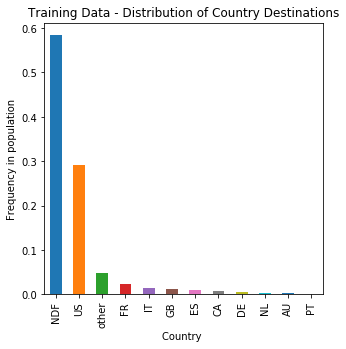

In [14]:
plt.rcParams['figure.figsize'] = [5, 5]
dfs['train_users_2'].country_destination.value_counts(normalize=True).plot.bar()
plt.title("Training Data - Distribution of Country Destinations")
plt.ylabel("Frequency in population")
plt.xlabel("Country ")

Text(0.5, 1.0, 'Training Data - NaN Value Patterns')

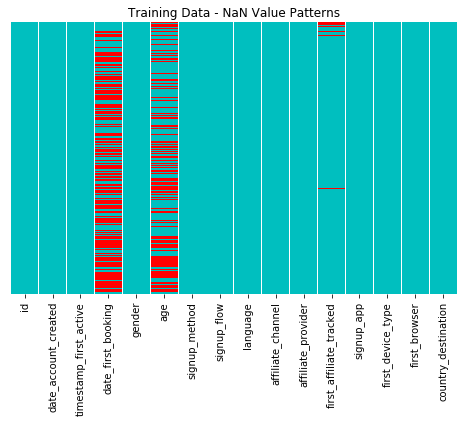

In [15]:
plt.rcParams['figure.figsize'] = [8, 5]
sns.heatmap(dfs['train_users_2'].isnull(), cbar=False, cmap=["c","r"], yticklabels=False)
plt.title("Training Data - NaN Value Patterns")

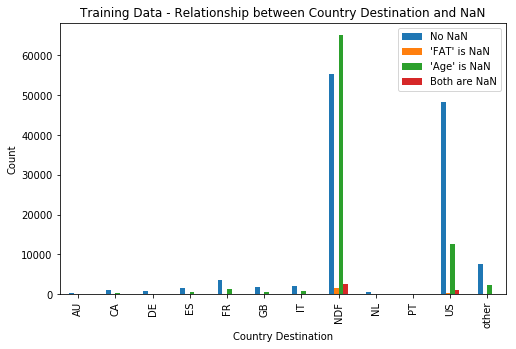

In [16]:
null_viz = dfs['train_users_2'].copy()
null_viz = null_viz.assign(age_is_nan=null_viz['age'].isnull())
null_viz = null_viz.assign(date_first_booking_is_nan=null_viz['date_first_booking'].isnull())
null_viz = null_viz.assign(first_affiliate_tracked_is_nan=null_viz['first_affiliate_tracked'].isnull())

#null_viz = null_viz[null_viz['age_is_nan'] | null_viz['date_first_booking_is_nan']]
null_viz = null_viz[['country_destination', 'age_is_nan', 'date_first_booking_is_nan', 'first_affiliate_tracked_is_nan']]

plt.rcParams['figure.figsize'] = [8, 5]
pd.crosstab(null_viz['country_destination'], [null_viz['age_is_nan'],null_viz['first_affiliate_tracked_is_nan']]).plot.bar()
plt.title("Training Data - Relationship between Country Destination and NaN")
plt.ylabel("Count")
plt.xlabel("Country Destination")
plt.legend(("No NaN","'FAT' is NaN","'Age' is NaN","Both are NaN"))

gender,-unknown-,FEMALE,MALE,OTHER
country_destination,,,,
AU,143,207,188,1
CA,491,455,477,5
DE,284,358,416,3
ES,715,853,677,4
FR,1713,1962,1335,13
GB,758,881,682,3
IT,1040,1091,699,5
NDF,66670,31048,26719,106
NL,227,254,278,3


Text(0.5, 1.0, 'Training Data - Destination by gender')

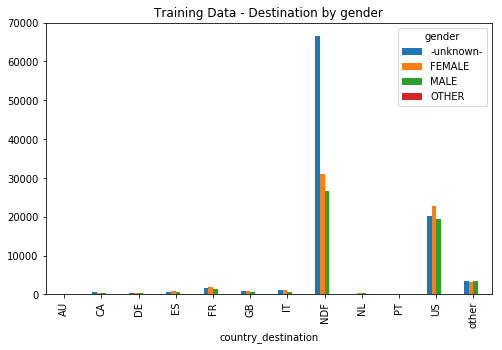

In [17]:
display(pd.crosstab(dfs['train_users_2']['country_destination'],dfs['train_users_2']['gender']))
pd.crosstab(dfs['train_users_2']['country_destination'],dfs['train_users_2']['gender']).plot.bar()
plt.title("Training Data - Destination by gender")

Text(0.5, 1.0, 'Training Data - Age by gender')

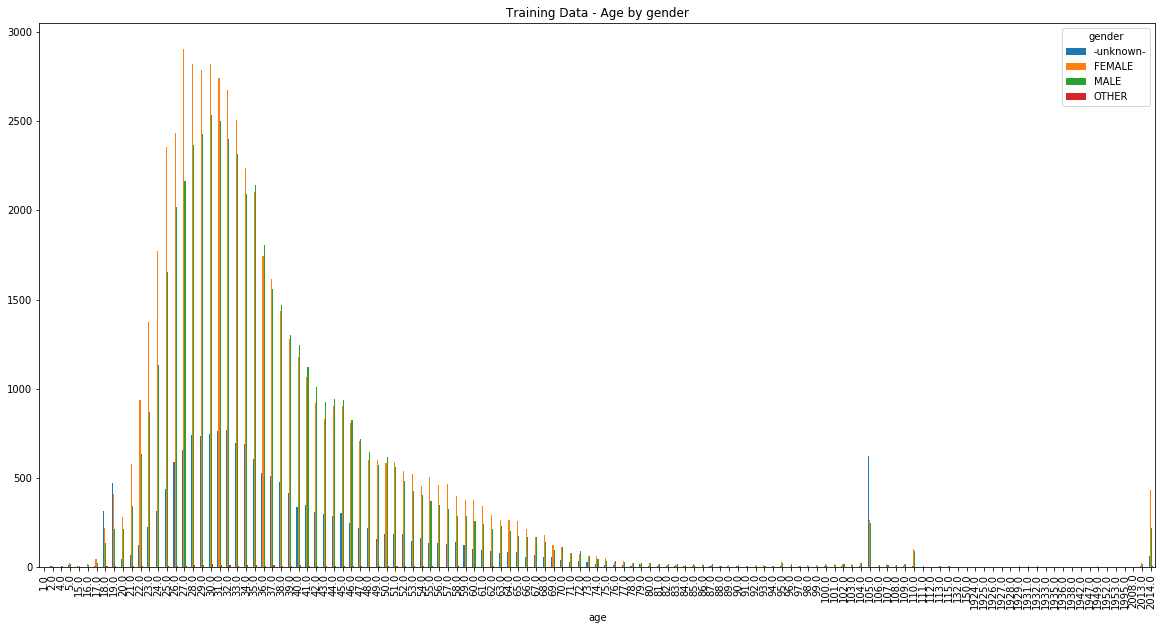

In [18]:
plt.rcParams['figure.figsize'] = [20, 10]
pd.crosstab(dfs['train_users_2']['age'],dfs['train_users_2']['gender']).plot.bar()
plt.title("Training Data - Age by gender")

Text(0.5, 1.0, 'Training Data - Destination by language spoken at destination and language of user')

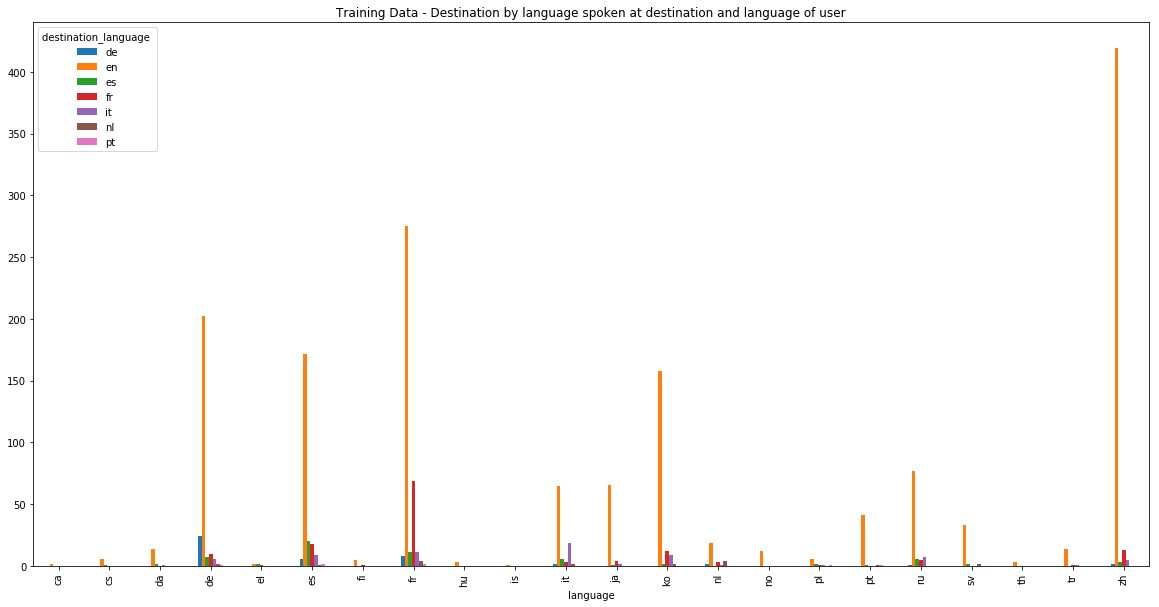

In [19]:
countriesWithLanguage = dfs['countries'].copy()
countriesWithLanguage['destination_language '] = pd.Series(['en', 'en', 'de', 'es', 'fr', 'en', 'it', 'nl', 'pt', 'en'])
joined_country = dfs['train_users_2'].join(countriesWithLanguage.set_index('country_destination'), on='country_destination')
joined_country_no_english = joined_country[joined_country['language'] != 'en']
plt.rcParams['figure.figsize'] = [20, 10]
ct = pd.crosstab(joined_country_no_english['language'],joined_country_no_english['destination_language ']).plot.bar()
plt.title("Training Data - Destination by language spoken at destination and language of user")

,english_speaking,non-english_speaking
0.00,0.846520,0.820473
63.22,0.009679,0.009259
72.61,0.013217,0.023148
89.40,0.035944,0.037037
92.06,0.063510,0.072531
92.25,0.028399,0.033951
95.45,0.002732,0.003601


Text(0.5, 0, 'Language Levenshtein Distance (0 is identical)')

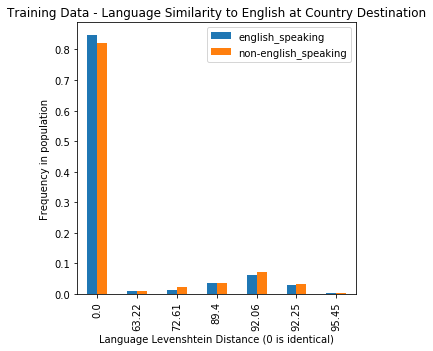

In [20]:
joined_country = dfs['train_users_2'].join(dfs['countries'].set_index('country_destination'), on='country_destination')
jc_other = joined_country[joined_country['language'] != 'en']['language_levenshtein_distance'].value_counts(normalize=True)
jc_english = joined_country[joined_country['language'] == 'en']['language_levenshtein_distance'].value_counts(normalize=True)

languages = pd.DataFrame({"english_speaking": jc_english, "non-english_speaking": jc_other})
#languages['language_levenshtein_distance'] = languages.index
languages.sort_index(inplace=True)
display(languages)

plt.rcParams['figure.figsize'] = [5, 5]
languages.plot.bar()
plt.title("Training Data - Language Similarity to English at Country Destination")
plt.ylabel("Frequency in population")
plt.xlabel("Language Levenshtein Distance (0 is identical)")

## Dataset: test_users

Description: This dataset is very similar to train_users_2, except it is missing booking information.
+ date_first_booking is all NaN
+ country_destination is missing

Relevance: We will test on this data after training our model.  Also it's important to understand the data in this set to guide what features will be available to us (no date_first_booking)

In [21]:
dfs['test_users'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62096 entries, 0 to 62095
Data columns (total 15 columns):
id                         62096 non-null object
date_account_created       62096 non-null object
timestamp_first_active     62096 non-null int64
date_first_booking         0 non-null float64
gender                     62096 non-null object
age                        33220 non-null float64
signup_method              62096 non-null object
signup_flow                62096 non-null int64
language                   62096 non-null object
affiliate_channel          62096 non-null object
affiliate_provider         62096 non-null object
first_affiliate_tracked    62076 non-null object
signup_app                 62096 non-null object
first_device_type          62096 non-null object
first_browser              62096 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 7.1+ MB


In [22]:
dfs['test_users'].head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


## Model Selection Methodology And Analysis

In order to generate predictions of destination countries, we examined a variety of machine learning algorithms.  In this next section, we will examine the efficacy of k-neighbors, Bernoulli Naive Bayes, Random Forest, Logistic Regression, and XGBoost.  While we will go into detail on each specific model, these models were selected due to their efficacy at solving customer purchase prediction problems or their efficacy at classifying imbalanced classes in available research and literature.  Given that our task is ultimately predicting customer behavior in an environment in which two choices are selected much more frequently than all others, we believe these choices to be appropriate for our use case.  Ultimately, inspired by both previous winners of this competition as well as additional research, we will combine our most effective and practical (evaluated by runtime) models into an ensemble voting classifier to generate the most robust predictions possible.

Throughout our process, we will compare accuracy scores and class-level F1 scores while optimizing our models to the optimal parameters for both "Weighted F1" scores and "Macro F1" scores.  Optimizing for "Weighted F1" scores will tune our models to a weighted average F1 score across all classes.  Given that our data contains significantly more examples of the "NDF" and "US" classes, the F1 scores for those two classes will largely dictate which parameters are deemed optimal.  Optimizing for "Macro F1" will maximize a non-weighted F1 score, meaning that the F1 score for each class is treated equally.  This typically results in uncommon classes being predicted more frequently, often at the expense of overall accuracy.

Due to the size of our dataset, we will most often be using a 10,000 record random sample from the training data for training, while testing on a much larger "development" set consisting of the remainder of the training set.  While we would prefer to use the full dataset in most cases, the full dataset made fitting several of our models nearly impossible.  Even when the models would fit appropriately, we saw no accuracy or F1 score gain from the additional training examples.  As a result, we feel comfortable that the sample is large enough and representative of our exhaustive dataset.  At times, we will train with a "balanced" training set consisting of an undersampled dataset with equal number of records for each class.  While this often significantly lowers the accuracy of each model, it does provide a helpful point of comparison.

Before creating any models, we will first establish a "baseline" accuracy score and classification report.  To do this, we will simply predict every record's label as "NDF", our most common class.  This will help us establish if our models are truly performing better than a simple "guess".

### Training and Development Data Setup

In [30]:
# Split into data and labels (panda dataframes).
#reduced this to 10k / 213k since it was taking forever to even test anything
#train_data   = dfs["train_users_2"][:10000].iloc[:, 0:-1] #we should randomize since accounts are in chronological order
#train_labels = dfs["train_users_2"][:10000]["country_destination"].ravel()

# Set train/dev split to 0.04685/0.95315 to give train size of 10k.  0.04685 = 10000/213451
test_size = 0.95315

# Use (train_test_split) to randomize train_users_2 before splitting into train/dev.
train_data, dev_data, train_labels, dev_labels = train_test_split(dfs["train_users_2"].iloc[:, 0:-1], dfs["train_users_2"].iloc[:, -1:], test_size=test_size, random_state=42)

# Final test data for Kaggle submission.
test_data = dfs["test_users"]

### Balanced Training Data Setup

Since the data is imbalanced, we will also create a set of balanced data.  This data is generated by re-sampling the under-represented classes.  The data will be evaluated as an option in model selection.

In [31]:
# Split training dataset into data and labels.
train_data_all = dfs["train_users_2"]
train_labels_all = dfs["train_users_2"].iloc[:, -1:]

# Evaluate existing representation of classes.
countries = train_labels_all['country_destination'].unique()

# Create pd for each country.
train_data_country = {}
train_labels_country = {}
min_count = -1
for country in countries:
    train_data_country[country] = train_data_all.loc[train_labels_all['country_destination'] == country]
    train_labels_country[country] = train_labels_all.loc[train_labels_all['country_destination'] == country]
    count = train_labels_country[country].shape[0]
    if (min_count == -1 or count < min_count):
        min_count = count

# Create balanced training dataset.
balanced_train_data = pd.DataFrame(columns=train_data_all.columns.values)
for country in countries:
    country_pd = train_data_country[country].sample(n=min_count, random_state=1)
    balanced_train_data = pd.concat([balanced_train_data, country_pd])
    
balanced_data = balanced_train_data.iloc[:, 0:-1]
balanced_labels = balanced_train_data.iloc[:,-1:]

### Feature Creation and Preprocessor Pipeline Setup

In [32]:
#Function to bucket ages prior to one-hot encoding
def age_bucketer(df_input):
    df = df_input
    df.loc[(pd.isnull(df.age), 'age_bucket')] = 'unknown'
    df.loc[(pd.notnull(df.age), 'age_bucket')] = pd.cut(df['age'],
                                                        [0, 4, 9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 79, 84, 89, 94,99,10000],
                                                        labels=['0-4', '5-9', '10-14','15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
                                                                '50-54', '55-59','60-64', '65-69','70-74','75-79','80-84','85-89','90-94','95-99','100+'],
                                                        include_lowest=True)
    return df.drop(['age'], axis=1)

#Since NaN's in categorical data will cause issues with our pipeline we will replace that with "unknown".
def clean_first_affiliate_tracked_nulls(df_input):
    df_input['first_affiliate_tracked'] = df_input['first_affiliate_tracked'].fillna("unknown", inplace=False)
    return df_input

#Add month and year features
def feature_creator (df_input):
    df = df_input
    df['first_active_date'] = pd.to_datetime(df.timestamp_first_active,format='%Y%m%d%H%M%S')
    df['year_first_active'] = df['first_active_date'].dt.year
    df['month_first_active'] = df['first_active_date'].dt.month
    df['season'] = ''
    df.loc[(df['month_first_active'].isin([12, 1, 2]), 'season')] = 'Winter'
    df.loc[(df['month_first_active'].isin([3, 4, 5]), 'season')] = 'Spring'
    df.loc[(df['month_first_active'].isin([6, 7, 8]), 'season')] = 'Summer'
    df.loc[(df['month_first_active'].isin([9, 10, 11]), 'season')] = 'Fall'
    return df.drop(['first_active_date'], axis=1) #consider dropping month as well

def date_first_booking_is_null(df_input):
    df_input = df_input.assign(date_first_booking_is_nan=df_input['date_first_booking'].isnull())
    return df_input

def session_feature_creator(df_input):
    df = df_input
    session_agg = dfs['sessions'].groupby('user_id').agg({"secs_elapsed": np.sum, "device_type": pd.Series.nunique, 'action': 'count'}).reset_index(
        ).rename(columns={'secs_elapsed':'total_time', 'device_type':'unique_device_types', 'action': 'unique_actions'})
    return df.merge(session_agg, left_on='id', right_on='user_id', how='left')

def nan_destroyer(df_input):
    # funcation to remove nans from numerical fields, need to determine strategy
    return none

def feautre_selector(df_input):
    # final function to remove IDs, repetitive features, and any features we do not want to be passed to our models
    return none

In [33]:
# Create Preprocessor pipeline.
def create_preprocessor_pipeline():

    column_transformer = make_column_transformer(
        (['gender',
          'signup_method',
          'signup_flow',
          'language',
          'affiliate_channel',
          'affiliate_provider',
          'first_affiliate_tracked',
          'signup_app',
          'first_device_type',
          'first_browser',
          'age_bucket',
          'season',
          'date_first_booking_is_nan'
         ], OneHotEncoder(handle_unknown='ignore')),remainder='drop') # when we add in sessions features we will want to pass remainders
    
    preprocessor = make_pipeline(
        FunctionTransformer(age_bucketer, validate=False),
        FunctionTransformer(feature_creator, validate=False),
        FunctionTransformer(date_first_booking_is_null, validate=False),
        FunctionTransformer(clean_first_affiliate_tracked_nulls, validate=False),
        column_transformer)
    
    return preprocessor

In [34]:
# Stage: Data Preprocessor.
preprocessor = create_preprocessor_pipeline()

In [35]:
score_dict = {}

### Baseline

In [36]:
dev_pred = dev_labels.copy()
dev_pred['country_destination'] = 'NDF'
accuracy = accuracy_score(dev_pred, dev_labels.values.ravel())
f1_weighted = f1_score(dev_pred, dev_labels.values.ravel(), average='weighted')
score_dict['Baseline'] = [accuracy, f1_weighted]
print('Accuracy: ',accuracy)
print(classification_report(dev_pred, dev_labels.values.ravel()))

c:\users\christmi\source\mids\w207_final_airbnb\w207-final\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy:  0.5832952406230493


c:\users\christmi\source\mids\w207_final_airbnb\w207-final\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00         0
          CA       0.00      0.00      0.00         0
          DE       0.00      0.00      0.00         0
          ES       0.00      0.00      0.00         0
          FR       0.00      0.00      0.00         0
          GB       0.00      0.00      0.00         0
          IT       0.00      0.00      0.00         0
         NDF       1.00      0.58      0.74    203451
          NL       0.00      0.00      0.00         0
          PT       0.00      0.00      0.00         0
          US       0.00      0.00      0.00         0
       other       0.00      0.00      0.00         0

   micro avg       0.58      0.58      0.58    203451
   macro avg       0.08      0.05      0.06    203451
weighted avg       1.00      0.58      0.74    203451



For the next few sections, we will refer to the above accuracy (58.32%) and classification report as our baseline.

### K-Neighbors Classifier

To begin, we start with a k-neighbors classifier.  In their paper *KNN Approach to Unbalanced Data Distributions*, Zhang and Mani demonstrate the effectiveness of a k-neighbors classifier at learning and accurately predicting minority classes without reducing the ability to predict common clases<sup>[13]</sup>.  Zhang and Mati also discuss the downsides of using other types of classifiers, particularly decision tree classifiers, when classes are heavily imbalanced. We test our model using 1, 3, 5, and 7 neighbors to see which is most effective.

#### Weighted F1 Optimization:

In [ ]:
params={'n_neighbors':[1,3,5,7], 'weights':['distance']}
knn = KNeighborsClassifier(n_jobs=-1)
knn_gs = GridSearchCV(knn, params, cv=3, scoring='f1_weighted', n_jobs=-1)
pipeline = make_pipeline(preprocessor, knn_gs)
pipeline.fit(train_data, train_labels.values.ravel())
dev_pred = pipeline.predict(dev_data)
accuracy = accuracy_score(dev_pred, dev_labels.values.ravel())
f1_weighted = f1_score(dev_pred, dev_labels.values.ravel(), average='weighted')
score_dict['KNN F1 Weighted'] = [accuracy, f1_weighted]
print('Accuracy: ',accuracy)
print(classification_report(dev_pred, dev_labels.values.ravel()))

In [ ]:
knn_gs.best_params_

#### Macro F1 Optimized:

In [ ]:
params={'n_neighbors':[1,3,5,7], 'weights':['distance']}
knn = KNeighborsClassifier(n_jobs=-1)
knn_gs = GridSearchCV(knn, params, cv=3, scoring='f1_macro', n_jobs=-1)
pipeline = make_pipeline(preprocessor, knn_gs)
pipeline.fit(train_data, train_labels.values.ravel())
dev_pred = pipeline.predict(dev_data)
accuracy = accuracy_score(dev_pred, dev_labels.values.ravel())
f1_weighted = f1_score(dev_pred, dev_labels.values.ravel(), average='weighted')
score_dict['KNN F1 Macro'] = [accuracy, f1_weighted]
print('Accuracy: ',accuracy)
print(classification_report(dev_pred, dev_labels.values.ravel()))

In [ ]:
knn_gs.best_params_

The model's performance, as well as the optimum number of neighbors, varies with both scoring method.  The weighted F1 optimized model has a higher accuracy of 57.06% as opposed to the macro F1 optimized score of 52.47%, but at the cost of lower precision and recall for minority classes.  However, in both cases, the accuracy scores and weighted F1 scores are below the baseline.  In addition, the weighted F1 optimized model performs best when trained with 7 neighbors, while the macro F1 optimized model performs best with only three neighbors.  This makes intuitive sense: given the imbalance in the data, the inclusion of more neighbors makes the model more likely to predict the common "NDF" and "US" classes, while fewer neighbors results in a higher likelihood of predicting uncommon classes.  Regardless, the F1 scores for minority classes are still low even when optimizing around macro F1 scores.  In an attempt to improve F1 for minority classes, we will train the models again, this time using the balanced dataset while optimizing for macro F1.

#### Balanced Dataset F1 Macro Optimized

In [ ]:
params={'n_neighbors':[1,3,5,7], 'weights':['distance']}
knn = KNeighborsClassifier(n_jobs=-1)
knn_gs = GridSearchCV(knn, params, cv=3, scoring='f1_macro', n_jobs = -1)
pipeline = make_pipeline(preprocessor, knn_gs)
pipeline.fit(balanced_data, balanced_labels.values.ravel())
dev_pred = pipeline.predict(dev_data)
accuracy = accuracy_score(dev_pred, dev_labels.values.ravel())
f1_weighted = f1_score(dev_pred, dev_labels.values.ravel(), average='weighted')
score_dict['KNN Balanced'] = [accuracy, f1_weighted]
print('Accuracy: ',accuracy)
print(classification_report(dev_pred, dev_labels.values.ravel()))

In [ ]:
knn_gs.best_params_

While this does significantly improve precision for a number of minority classes, recall is largely unchanged resulting in only moderate improvements to F1 for uncommon classes, as well as a drop in overall F1.  This model performs significantly worse than the baseline on almost all measures.  We will explore this further in the remaining model training, but this could possibly indicate a lack of feature distinction between the uncommon and common classes, making it difficult for most models to accurately predict the uncommon classes.

In [ ]:
#Free some memory
del knn, knn_gs

### Bernoulli Naive Bayes

We will now examine the efficacy of a Bernoulli Naive Bayes model.  Our rationale for choosing this model is do to the quantity of binary features in our post-pipeline dataset.  Given the high number of categorical features, which are one-hot encoded during our pipeline process, we suspect Bernoulli Naive Bayes may perform effectively.  As with KNN, we will examine the efficacy of optimizing the model for both weighted and macro F1 scores, as well as optimizing on the balanced dataset.

#### Weighted F1 Optimized:

In [ ]:
params={'alpha': [1.05, .1]}
bnb = BernoulliNB()
bnb_gs = GridSearchCV(bnb, params, cv=3, scoring='f1_weighted', n_jobs=-1)
pipeline = make_pipeline(preprocessor, bnb_gs)
pipeline.fit(train_data, train_labels.values.ravel())
dev_pred = pipeline.predict(dev_data)
accuracy = accuracy_score(dev_pred, dev_labels.values.ravel())
f1_weighted = f1_score(dev_pred, dev_labels.values.ravel(), average='weighted')
score_dict['Bernoulli Naive Bayes F1 Weighted'] = [accuracy, f1_weighted]
print('Accuracy: ',accuracy)
print(classification_report(dev_pred, dev_labels.values.ravel()))

In [ ]:
bnb_gs.best_params_

#### Macro F1 Optimized:

In [ ]:
params={'alpha': [1.05, .1]}
bnb = BernoulliNB()
bnb_gs = GridSearchCV(bnb, params, cv=3, scoring='f1_macro', n_jobs=-1)
pipeline = make_pipeline(preprocessor, bnb_gs)
pipeline.fit(train_data, train_labels.values.ravel())
dev_pred = pipeline.predict(dev_data)
accuracy = accuracy_score(dev_pred, dev_labels.values.ravel())
f1_weighted = f1_score(dev_pred, dev_labels.values.ravel(), average='weighted')
score_dict['Bernoulli Naive Bayes F1 Macro'] = [accuracy, f1_weighted]
print('Accuracy: ',accuracy)
print(classification_report(dev_pred, dev_labels.values.ravel()))

In [ ]:
bnb_gs.best_params_

After tuning the Laplace smoothing parameters (alpha) for the weighted and macro F1 optimized model versions, we see that the macro F1-optimized model performs best under a significantly smaller (0.1) alpha, corresponding to stronger smoothing.  However, in spite of the difference in optimized tuning parameters, both models perform very similarly, with accuracy scores slightly below our baseline.  In comparison to the KNN models, both models show improvement at predicting "US" classes at the expense of predicting "NDF" classes.  Still, both models perform rather poorly when predicting uncommon classes.  Once again, we will examine if balancing the dataset has any effect.

#### Balanced Macro F1 Optimized:

In [ ]:
params={'alpha': [1.05, .1]}
bnb = BernoulliNB()
bnb_gs = GridSearchCV(bnb, params, cv=3, scoring='f1_macro', n_jobs=-1)
pipeline = make_pipeline(preprocessor, bnb_gs)
pipeline.fit(balanced_data, balanced_labels.values.ravel())
dev_pred = pipeline.predict(dev_data)
accuracy = accuracy_score(dev_pred, dev_labels.values.ravel())
f1_weighted = f1_score(dev_pred, dev_labels.values.ravel(), average='weighted')
score_dict['Bernoulli Naive Bayes Balanced'] = [accuracy, f1_weighted]
print('Accuracy: ',accuracy)
print(classification_report(dev_pred, dev_labels.values.ravel()))

In [ ]:
bnb_gs.best_params_

As with KNN, we see a slight improvement in F1 scores for some uncommon classes at the expense of overall F1 scores.  Furthermore, this model experiences a significant drop in prediction accuracy, with the model predicting several uncommon classes with higher frequency than "US" class predictions.  Given that all Naive Bayes models depend on priors derived from the frequency of classes found in the data, balancing the dataset results in significant overprediction of minority classes.  In their paper *Tackling the Poor Assumptions of Naive Bayes Text Classifiers*, Rennie, Shih, Teevan, and Karger state that Naive Bayes classifiers typically perform poorly when there are few training examples due to an inherent bias effect, which is on full display here<sup>[14]</sup>.

## Logistic Regression

Next, we will optimize two logistic regression models: one with class balancing applied and one without.  We will do so while optimizing the regularization parameters, identifying the optimum value of 'C' for both l1 and l2 penalties.  We chose to include logistic regressions due to their widespread use and documented history of success on imbalanced datasets.  In their paper *An experimental comparison of classification algorithms for imbalanced credit scoring data sets*, Brown and Mues show logistic regression performing fairly effectively on imbalanced credit score data, and show additional prior research confirming this finding<sup>[15]</sup>.

#### Class Balanced:

In [ ]:
params={'C':[.001,.01, .1, 1, 10, 100, .007], 'penalty':['l1', 'l2']}
lr = LogisticRegression(class_weight = 'balanced', tol=.01)
lr_gs = GridSearchCV(lr, params, cv=3, scoring='f1_weighted', n_jobs=-1)
pipeline = make_pipeline(preprocessor, lr_gs)
pipeline.fit(train_data, train_labels.values.ravel())
dev_pred = pipeline.predict(dev_data)
accuracy = accuracy_score(dev_pred, dev_labels.values.ravel())
f1_weighted = f1_score(dev_pred, dev_labels.values.ravel(), average='weighted')
score_dict['Logistic Regression Class Balanced'] = [accuracy, f1_weighted]
print('Accuracy: ',accuracy)
print(classification_report(dev_pred, dev_labels.values.ravel()))

In [ ]:
lr_gs.best_params_

#### No Class Balancing:

In [ ]:
params={'C':[.001,.01, .1, 1, 10, 100, .007], 'penalty':['l1', 'l2']}
lr = LogisticRegression(tol=.01)
lr_gs = GridSearchCV(lr, params, cv=3, scoring='f1_weighted', n_jobs=-1)
pipeline = make_pipeline(preprocessor, lr_gs)
pipeline.fit(train_data, train_labels.values.ravel())
dev_pred = pipeline.predict(dev_data)
accuracy = accuracy_score(dev_pred, dev_labels.values.ravel())
f1_weighted = f1_score(dev_pred, dev_labels.values.ravel(), average='weighted')
score_dict['Logistic Regression No Class Balancing'] = [accuracy, f1_weighted]
print('Accuracy: ',accuracy)
print(classification_report(dev_pred, dev_labels.values.ravel()))

In [ ]:
lr_gs.best_params_

While each model optimizes around different penalty and penalty types, the non-class balanced model returns zero predictions for all classes other than "NDF" and "US".  In spite of this, the non-class balanced model offers a further two percentage point accuracy increase over the non-class balanced random forest model, as well as the highest weighted F1 score thus far.

## Random Forst Classifier

While Zhang and Mani identify some of the drawbacks of decision tree classifiers at predicting imblanced classes, Random Forest Classifiers have been shown to be effective at predicting imbalanced classes in some cases.  In *Using Random Forest to Learn Imbalanced Data*, Chen, Liaw, and Breiman describe the usage of "balancing" features, similar to the one found in Scikit-Learn's Random Forest Classifier Package, as being effective with heavily imbalanced classes<sup>[16]</sup>.   As a result, we will optimize two models, one using Scikit-Learn's built-in class balancing feature and one without any additional class balancing.  

#### Class Balanced:

In [ ]:
params={'n_estimators':[300], 'max_depth':[5,10,20]}
rf = RandomForestClassifier(n_jobs = -1, class_weight = 'balanced_subsample')
rf_gs = GridSearchCV(rf, params, cv=3, scoring='f1_weighted', n_jobs=-1)
pipeline = make_pipeline(preprocessor, rf_gs)
pipeline.fit(train_data, train_labels.values.ravel())
dev_pred = pipeline.predict(dev_data)
accuracy = accuracy_score(dev_pred, dev_labels.values.ravel())
f1_weighted = f1_score(dev_pred, dev_labels.values.ravel(), average='weighted')
score_dict['Random Forest Class Balanced'] = [accuracy, f1_weighted]
print('Accuracy: ',accuracy)
print(classification_report(dev_pred, dev_labels.values.ravel()))

In [ ]:
rf_gs.best_params_

#### No Class Balancing:

In [ ]:
params={'n_estimators':[300], 'max_depth':[5,10,20]}
rf = RandomForestClassifier(n_jobs = -1)
rf_gs = GridSearchCV(rf, params, cv=3, scoring='f1_weighted', n_jobs=-1)
pipeline = make_pipeline(preprocessor, rf_gs)
pipeline.fit(train_data, train_labels.values.ravel())
dev_pred = pipeline.predict(dev_data)
accuracy = accuracy_score(dev_pred, dev_labels.values.ravel())
f1_weighted = f1_score(dev_pred, dev_labels.values.ravel(), average='weighted')
score_dict['Random Forest No Class Balancing'] = [accuracy, f1_weighted]
print('Accuracy: ',accuracy)
print(classification_report(dev_pred, dev_labels.values.ravel()))

In [ ]:
rf_gs.best_params_

As expected, the class-balanced model has slightly higher uncommon class F1 scores than the model without balancing.  However, this comes with a cost of significantly reduced accuracy and weighted F1 scores, well below our baseline.  On the other hand, the non-balanced model returns an accuracy score three percentage points above our baseline.

In [ ]:
#free memory
del rf, rf_gs

## XGBoost

For our final model, we will use XGBoost, another tree-based model similar to Random Forest, but with compounding decision trees building off of each other rather than individual trees "voting" for the best prediction.  While our motivation for partly due to the success of this algorithm with other users on Kaggle, we believe XGBoost's natural regularization may offer similar performance to Random Forest.  In their paper *XGBoost: A Scalable Tree Boosting System*, Chen and Guestrin describe the flexibility of the model, as well as its ability to scale quickly to larger datasets<sup>[17]</sup>.  While XGBoost may not prove the most effective model for the purposes of this competition, it may provide a scalable alternative for even larger datasets or a substitute in a production system.  Thus, we think it is worth pursuing. As with some of our previous examples, we will first optimize a model using the full training set before using a balanced class dataset.

#### Full Training Set:

In [ ]:
params={'booster':['gbtree', 'gblinear','dart']}
xgb = XGBClassifier(nthread=-1)
xgb_gs = GridSearchCV(xgb, params, cv=3, scoring='f1_weighted', n_jobs=-1)
pipeline = make_pipeline(preprocessor, xgb_gs)
pipeline.fit(train_data, train_labels.values.ravel())
dev_pred = pipeline.predict(dev_data)
accuracy = accuracy_score(dev_pred, dev_labels.values.ravel())
f1_weighted = f1_score(dev_pred, dev_labels.values.ravel(), average='weighted')
score_dict['XG Boost Full Training Set'] = [accuracy, f1_weighted]
print('Accuracy: ',accuracy)
print(classification_report(dev_pred, dev_labels.values.ravel()))

In [ ]:
xgb_gs.best_params_

#### Balanced Training Dataset:

In [ ]:
#params={'reg_lambda':[100]}
params={'booster':['gbtree', 'gblinear','dart']}
xgb = XGBClassifier(nthread=-1)
xgb_gs = GridSearchCV(xgb, params, cv=3, scoring='f1_weighted', n_jobs=-1)
pipeline = make_pipeline(preprocessor, xgb_gs)
pipeline.fit(balanced_data, balanced_labels.values.ravel())
dev_pred = pipeline.predict(dev_data)
accuracy = accuracy_score(dev_pred, dev_labels.values.ravel())
f1_weighted = f1_score(dev_pred, dev_labels.values.ravel(), average='weighted')
score_dict['XG Boost Balanced Training Set'] = [accuracy, f1_weighted]
print('Accuracy: ',accuracy)
print(classification_report(dev_pred, dev_labels.values.ravel()))

In [ ]:
xgb_gs.best_params_

Similar to logistic regression, the non-class balanced trained model only returns predictions of "NDF" or "US", but does so with a relatively high accuracy score.  The balanced model returns more predictions for the uncommon classes, but at a cost of overall accuracy and F1, similar to our prior examples.

### Ensemble Voting Classifier

Thus far, our models have returned similar results with varying levels of efficacy.  In all cases, balancing classes results in more predictions of uncommon classes, to the detriment of overall accuracy and weighted F1 scores. In fact, the two classifiers with the highest accuracy both predict no instances of uncommon classes.  We suspect this is due to examples of uncommon classes having similar feature values to the more common classes.  Our models are able to parse between likely "NDF" and non-"NDF" examples, but are unable to accurately predict any non-"NDF" classes outside of "US".

In a final attempt to improve our predictions, we will try combining classifiers through a "Voting Classifier".  This classifier will utilize predictions from multiple individual classifiers to pick a single prediction for each instance.  When set to "hard" voting each classifier has a single vote, while setting the voting to "soft" will generate predictions based on weighted averages derived from the strength(probability) of the prediction from each individual model.

In [ ]:
# Train

bnb = BernoulliNB(alpha=1.05)
rf = RandomForestClassifier(n_jobs = -1, n_estimators=300, max_depth=10, class_weight='balanced')
lr = LogisticRegression()
xgb = XGBClassifier(n_jobs=-1)

vc = VotingClassifier(estimators = [('bnb', bnb),
                                    ('rf', rf),
                                    ('lr', lr),
                                    ('xgb', xgb)], voting='hard')

pipeline = make_pipeline(preprocessor, vc)

In [ ]:
pipeline.fit(train_data, train_labels.values.ravel())
dev_pred = pipeline.predict(dev_data)
accuracy = accuracy_score(dev_pred, dev_labels.values.ravel())
f1_weighted = f1_score(dev_pred, dev_labels.values.ravel(), average='weighted')
score_dict['Voting Classifier'] = [accuracy, f1_weighted]
print('Accuracy: ',accuracy)
print(classification_report(dev_pred, dev_labels.values.ravel()))

After testing a variety of parameters, we eventually exclude the KNN model as it reduced both F1 and accuracy scores.  Our voting classifier model returns similar accuracy and weighted F1 scores to our top performing individual models, but with a handful of predictions for uncommon classes.  This indicates that our models are likely "learning" similar patterns.  Given that no improvement is gained through combining models, our models are returning the same predictions for the vast majority of instances.  As a result, we believe that additional features are needed for additional improvement.

## Conclusion

In the previous sections, we analyzed Airbnb user data and trained several machine learning classifiers in order to predict the user's first destination country. To compare the performance of each model, we graph the model accuracies and weighted F1 scores below:

In [ ]:
score_df = pd.DataFrame(
    {'Model': list(score_dict.keys()),
     'Accuracy': [item[0] for item in list(score_dict.values())],
     'Weighted F1': [item[1] for item in list(score_dict.values())]    
    }
)

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Model', data=score_df, color="b")

plt.xlabel('Accuracy %')
plt.title('Model Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Weighted F1', y='Model', data=score_df, color="g")

plt.xlabel('Weighted F1')
plt.title('Model Weighted F1')
plt.show()

As shown in the accuracy and F1 comparisons above, only a handful of the models offer improvement over the baseline.  Given that the Voting Classifier offers no improvement over the individual Logistic Regression and XGBoost models, we would favor either of those options over the Voting Classifier simply due to the simplicity.  While both Logistic Regression and XGBoost offer similar performance, we favor XGBoost due to its slight edge in accuracy and ability to scale.  Given the descriptions Chen and Guestrin describe in their paper, we believe the XGBoost model is likely to improve the most with additional data and features, and thus believe it is a valid choice for our final model.  Our recommendation would therefore be to utilize our upfront preprocessing pipeline along with an XGBoost model trained on a dataset without class balancing applied.

While our model is more effective than the baseline, we believe significant improvement could be gained from additional features.  The datasets provided by Kaggle included only demographic and user session data, but both types of datasets were fairly limited.  We ultimately discarded the sessions data after it provided no measurable improvement to our models at the cost of increased training time.  This is because the sessions data only contained high-level action descriptions, such as actions consisting of a user search without specifying for what the user searched.  If more detailed demographic information or more specific user actions such as search destinations were provided, we believe the models could be significantly improved.

Under our recommended model, we managed to improved the accuracy over our baseline by five percentage points, highlighting the power of machine learning on even relatively weakly-indicative features.  This process, however, highlights the importance of identifying and capturing useful features that are likely to help answer a desired question.  While we certainly believe our model would be a useful tool to Airbnb, we are almost certain they have developed more robust and accurate models to answer our research question with the features they have at their disposal.

### Submission to Kaggle

For the purposes of answering our research question, we optimized our models to generate the single best prediction for test user.  The Kaggle competition allows for the submission of up to five ranked guesses per each test example, with penalties applied for each additional wrong guess.  This provides another layer of optimization somewhat outside the scope of answering our research question.  As a result, we did not focus on optimizing the scores around generating multiple guesses.

In [ ]:
#Implement XGBoost Model
params={'booster':['gbtree', 'gblinear','dart']}
xgb = XGBClassifier(nthread=-1)
xgb_gs = GridSearchCV(xgb, params, cv=3, scoring='f1_weighted', n_jobs=-1)
pipeline = make_pipeline(preprocessor, xgb_gs)
pipeline.fit(train_data, train_labels.values.ravel())

# Generate predictions for test data to submit to Kaggle for scoring.
predictions = pipeline.predict(test_data)

# Save to csv
final_csv = 'kaggle_submission.csv'
predictions_pd = pd.DataFrame(data=predictions, columns=['country'])
test_result = pd.concat([test_data['id'], predictions_pd], axis=1, sort=False)
test_result.to_csv(final_csv, index=False)
print("WRITTEN: %s" %(final_csv))

Kaggle Score:

<img src="kaggle_score.png" align="center"/>

Even though we did not optimize for multiple predictions, our model managed to beat the baseline Kaggle score of $.68411$.

## References

[1] “Airbnb New User Bookings - Description” Kaggle, 24 Nov. 2015, https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings#description.

[2] Molnar, Christoph “Feature Importance” Interpretable Machine Learning, https://christophm.github.io/interpretable-ml-book/feature-importance.html.

[3] Fisher, Rudin, and Dominici “All Models are Wrong but many are Useful: Variable Importance for Black-Box, Proprietary, or Misspecified Prediction Models, using Model Class Reliance” arXiv, https://arxiv.org/abs/1801.01489v3.

[4] “Airbnb New User Bookings - Evaluation” Kaggle, 24 Nov. 2015, https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings#evaluation.

[5]  Smolyakov, Vadim. “Ensemble Learning to Improve Machine Learning Results.” <i>Stats and Bots</i>, 22 Aug. 2017, blog.statsbot.co/ensemble-learning-d1dcd548e936.

[6]  Zinkevich, M. 2017. Rules of Machine Learning: Best Practices for ML Engineering.  http://martin.zinkevich.org/rules_of_ml/rules_of_ml.pdf.

[7]  “Airbnb New User Bookings, Winner's Interview: 2nd Place, Keiichi Kuroyanagi (@Keiku).” <i>No Free Hunch</i>, 15 Mar. 2016, blog.kaggle.com/2016/03/17/airbnb-new-user-bookings-winners-interview-2nd-place-keiichi-kuroyanagi-keiku/.

[8]  Shekhar, Amit. “What Is Feature Engineering for Machine Learning? – MindOrks – Medium.” <i>Medium.com</i>, Medium, 14 Feb. 2018, medium.com/mindorks/what-is-feature-engineering-for-machine-learning-d8ba3158d97a.

[9]  “Airbnb New User Bookings, Winners Interview: 3rd Place: Sandro Vega Pons.” <i>No Free Hunch</i>, 15 Mar. 2016, blog.kaggle.com/2016/03/07/airbnb-new-user-bookings-winners-interview-3rd-place-sandro-vega-pons/.

[10]  Kumar, Ajitesh. “Machine Learning: Validation Techniques - DZone AI.” <i>Dzone.com</i>, 12 Feb. 2018, dzone.com/articles/machine-learning-validation-techniques.

[11]  Brownlee, Jason. “Data Leakage in Machine Learning.” <i>Machine Learning Mastery</i>, 31 July 2018, machinelearningmastery.com/data-leakage-machine-learning/.

[12]  Brownlee, Jason. “A Gentle Introduction to XGBoost for Applied Machine Learning.” <i>Machine Learning Mastery</i>, 21 Sept. 2016, machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/.

[13] Zhang and Mani. “kNN Approach to Unbalanced Data Distributions” Georgetown University, Aug 2003, https://www.site.uottawa.ca/~nat/Workshop2003/jzhang.pdf

[14] Rennie, Shih, Teevan, and Karger. “Tackling the Poor Assumptions of Naive Bayes Text Classifiers” MIT, Aug 24 2003, https://people.csail.mit.edu/jrennie/papers/icml03-nb.pdf

[15] Brown and Mues. “An experimental comparison of classification algorithms for imbalanced credit scoring data sets" University of Southampton, Sep 8 2011, https://ac.els-cdn.com/S095741741101342X/1-s2.0-S095741741101342X-main.pdf?_tid=3b8964bd-0bd4-4dc4-be77-42d9a8e2e84e&acdnat=1544577102_68a1229f0d71032b4796e9feb64cb601

[16] Chen, Liaw, and Breiman. “Using Random Forest to Learn Imbalanced Data" University of California, Berkeley, July 2004, https://statistics.berkeley.edu/tech-reports/666

[17] Chen and Guestrin. “XGBoost: A Scalable Tree Boosting System" University of Washington, Seattle, August 17 2016 https://arxiv.org/pdf/1603.02754.pdf